In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## EDA

In [2]:
X_train = train.drop('label', axis=1)
Y_train = train['label'].copy()

看數字的分佈

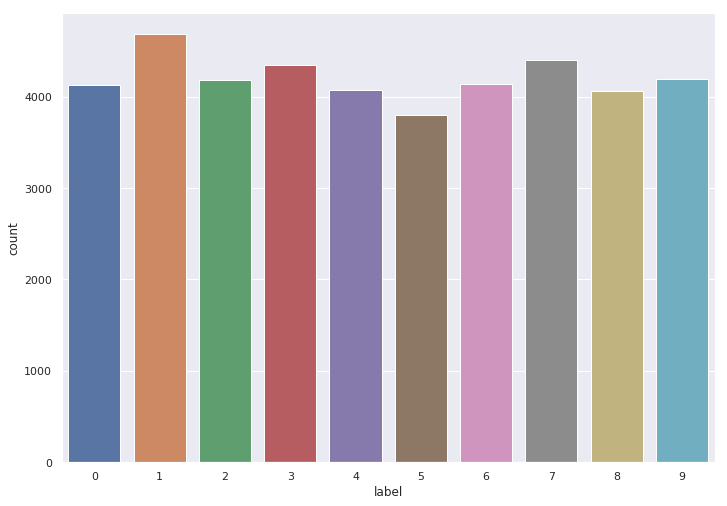

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.countplot(Y_train)

## preprocessing

In [4]:
# .isna().sum()計算每個pixel內各自的缺失值數量, 再sum()計算全部的缺失值總和
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


Normalization

In [5]:
X_train = X_train / 255.0
test = test / 255.0

做PCA
> 可以大幅度減少tree模型的訓練時間 

![](https://pocket-image-cache.com/direct?url=https%3A%2F%2Fcdn-images-1.medium.com%2Fmax%2F1600%2F1*Gob8ZbScyM7hHUHjvrMJYg.png)
保留下重要特徵與原圖的差距

In [6]:
from sklearn.decomposition import PCA
# 保留95%的重要資訊，sklearn會自行決定要留下多少feature
pca = PCA(.95)
# 訓練pca僅用training data
pca.fit(X_train)
# 將所有資料降維
X_train_arr = pca.transform(X_train)
test_arr = pca.transform(test)
# numpy arrray to pandas dataframe
X_train = pd.DataFrame(X_train_arr)
test = pd.DataFrame(test_arr)

In [7]:
pd.DataFrame(X_train_arr).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153
0,-2.594493,-2.742397,0.718753,0.472986,-0.317968,1.919458,-2.680278,0.335527,1.366855,0.795994,-1.429647,0.083395,1.586045,-0.380598,0.242510,-0.340314,0.069248,1.119548,0.073833,0.814285,0.173504,0.870174,0.224421,-0.583039,0.056249,-0.162965,-1.308720,0.819525,0.234563,0.331586,0.027227,-0.020784,0.767488,-0.208742,-0.027018,-0.576026,-0.193751,-0.345349,-0.633683,-0.552108,...,0.042162,0.007055,-0.059253,0.005802,0.023404,0.257484,-0.025958,-0.097947,-0.043374,-0.064835,0.050500,0.092524,-0.083865,-0.132635,0.178157,0.116970,0.125725,0.081857,0.002642,-0.096908,0.055835,-0.020189,0.079632,-0.016643,0.107711,0.097826,-0.025712,-0.041785,-0.002237,-0.012164,-0.067053,-0.228781,0.062052,-0.036420,-0.072481,-0.072631,-0.022244,-0.132079,-0.213691,-0.038430
1,6.672360,-1.413928,-1.967865,1.315387,-1.734819,2.895702,2.564217,-0.692552,-0.029491,0.266064,0.134203,0.182556,-0.276219,-1.343891,1.481725,-0.022219,1.246140,0.343579,-0.370710,-0.686385,-0.835634,-1.068282,0.028108,-0.088765,-0.135720,1.037204,-0.300478,0.055004,-0.315401,-0.343863,-0.109108,0.740330,0.454718,0.227144,-0.040960,-0.359751,-0.433390,-0.159229,0.438615,0.341620,...,0.190305,-0.348646,0.090934,0.170764,0.030406,-0.183059,-0.114829,0.261246,-0.114586,-0.039738,0.139480,-0.216929,-0.213011,-0.214740,0.157430,0.115800,0.044552,0.105842,0.073442,-0.190964,-0.152118,0.062028,0.010433,-0.083411,-0.013305,0.127820,-0.194225,-0.046982,0.087129,0.005973,-0.170224,-0.143102,0.160708,-0.041902,0.259691,0.126643,0.042588,-0.072776,0.046247,0.160540
2,-3.478017,-1.152023,0.263354,0.306917,-1.857709,-1.268787,1.716859,-1.197560,-0.765865,-0.100494,1.441551,0.988654,0.213953,-0.229768,0.639571,-0.637232,-0.393406,-0.609292,0.275313,-0.716853,-0.411531,0.504420,0.596115,0.205473,-0.442643,0.345662,-0.900340,0.419323,-0.041236,0.475935,0.345657,0.159555,-0.191848,-0.462948,-0.066174,-0.007045,-0.203213,0.260578,-0.451015,-0.150124,...,0.070577,-0.101961,0.069095,0.098405,-0.107572,-0.099631,-0.003580,0.069428,0.007075,0.066349,0.014183,-0.086456,-0.121493,0.157056,0.171558,0.190175,-0.179625,0.323027,0.065272,-0.156148,0.018592,0.053685,0.091161,-0.202296,0.074445,0.048547,-0.204672,-0.047115,-0.061178,-0.055456,-0.054435,0.147788,0.115108,-0.050937,-0.236927,0.021184,0.044644,0.051675,-0.053659,0.080727
3,-0.650022,1.177187,-0.251551,2.979240,-1.669978,0.617217,-1.192546,1.083957,-0.179871,-1.158736,-0.010771,-1.007389,-0.344056,-0.687691,0.157066,-0.343280,0.212858,0.783722,-0.046377,1.168987,-0.910431,-0.352372,1.147972,0.493423,-0.269416,-0.758524,-0.722504,0.325087,0.840978,0.749719,-0.403796,-0.119798,0.455897,0.059988,0.460753,0.449337,-0.259652,0.292790,0.108424,0.466982,...,0.095780,-0.159543,0.338171,0.450341,0.227038,0.088504,-0.381029,0.015967,-0.064121,-0.076896,0.078043,0.498996,0.049122,-0.178681,0.232074,-0.222672,-0.545324,-0.430639,0.393172,0.080705,0.022745,0.024658,0.381817,-0.073454,-0.037300,-0.055809,0.083063,-0.360913,0.034892,0.302081,-0.018192,0.267381,0.372009,-0.061265,-0.377509,0.186855,-0.163933,-0.041687,-0.080425,0.046430
4,7.543960,-1.761385,-2.151424,0.739432,-2.555829,3.882603,2.213753,-1.003589,0.489862,0.696341,-0.076439,1.308713,-0.835515,-1.390759,0.366575,0.105075,0.913702,-0.214665,-0.177814,-1.004744,-0.061405,-0.514300,-0.550263,-0.223264,0.689642,-0.034043,0.197304,-0.638136,-0.272431,0.097046,-0.141353,-0.023278,0.052476,-0.113904,-0.522997,0.269753,-0.311092,0.151360,-0.055903,-0.352880,...,0.306167,-0.129209,-0.083127,0.036178,-0.140413,0.181076,-0.169837,0.367010,0.175383,0.008208,0.144197,-0.239962,0.008192,-0.199198,-0.002035,0.004940,0.006674,0.126977,0.131404,0.006020,0.084780,0.194413,-0.088493,-0.148069,0.222524,-0.059107,-0.026122,0.175153,-0.083018

In [8]:
# 把label加回來
X_train = pd.concat([train['label'], X_train], axis=1)

In [9]:
# 暫時只用前十筆資料
X_train = X_train.head(300)
X_train.head()

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153
0,1,-2.594493,-2.742397,0.718753,0.472986,-0.317968,1.919458,-2.680278,0.335527,1.366855,0.795994,-1.429647,0.083395,1.586045,-0.380598,0.242510,-0.340314,0.069248,1.119548,0.073833,0.814285,0.173504,0.870174,0.224421,-0.583039,0.056249,-0.162965,-1.308720,0.819525,0.234563,0.331586,0.027227,-0.020784,0.767488,-0.208742,-0.027018,-0.576026,-0.193751,-0.345349,-0.633683,...,0.042162,0.007055,-0.059253,0.005802,0.023404,0.257484,-0.025958,-0.097947,-0.043374,-0.064835,0.050500,0.092524,-0.083865,-0.132635,0.178157,0.116970,0.125725,0.081857,0.002642,-0.096908,0.055835,-0.020189,0.079632,-0.016643,0.107711,0.097826,-0.025712,-0.041785,-0.002237,-0.012164,-0.067053,-0.228781,0.062052,-0.036420,-0.072481,-0.072631,-0.022244,-0.132079,-0.213691,-0.038430
1,0,6.672360,-1.413928,-1.967865,1.315387,-1.734819,2.895702,2.564217,-0.692552,-0.029491,0.266064,0.134203,0.182556,-0.276219,-1.343891,1.481725,-0.022219,1.246140,0.343579,-0.370710,-0.686385,-0.835634,-1.068282,0.028108,-0.088765,-0.135720,1.037204,-0.300478,0.055004,-0.315401,-0.343863,-0.109108,0.740330,0.454718,0.227144,-0.040960,-0.359751,-0.433390,-0.159229,0.438615,...,0.190305,-0.348646,0.090934,0.170764,0.030406,-0.183059,-0.114829,0.261246,-0.114586,-0.039738,0.139480,-0.216929,-0.213011,-0.214740,0.157430,0.115800,0.044552,0.105842,0.073442,-0.190964,-0.152118,0.062028,0.010433,-0.083411,-0.013305,0.127820,-0.194225,-0.046982,0.087129,0.005973,-0.170224,-0.143102,0.160708,-0.041902,0.259691,0.126643,0.042588,-0.072776,0.046247,0.160540
2,1,-3.478017,-1.152023,0.263354,0.306917,-1.857709,-1.268787,1.716859,-1.197560,-0.765865,-0.100494,1.441551,0.988654,0.213953,-0.229768,0.639571,-0.637232,-0.393406,-0.609292,0.275313,-0.716853,-0.411531,0.504420,0.596115,0.205473,-0.442643,0.345662,-0.900340,0.419323,-0.041236,0.475935,0.345657,0.159555,-0.191848,-0.462948,-0.066174,-0.007045,-0.203213,0.260578,-0.451015,...,0.070577,-0.101961,0.069095,0.098405,-0.107572,-0.099631,-0.003580,0.069428,0.007075,0.066349,0.014183,-0.086456,-0.121493,0.157056,0.171558,0.190175,-0.179625,0.323027,0.065272,-0.156148,0.018592,0.053685,0.091161,-0.202296,0.074445,0.048547,-0.204672,-0.047115,-0.061178,-0.055456,-0.054435,0.147788,0.115108,-0.050937,-0.236927,0.021184,0.044644,0.051675,-0.053659,0.080727
3,4,-0.650022,1.177187,-0.251551,2.979240,-1.669978,0.617217,-1.192546,1.083957,-0.179871,-1.158736,-0.010771,-1.007389,-0.344056,-0.687691,0.157066,-0.343280,0.212858,0.783722,-0.046377,1.168987,-0.910431,-0.352372,1.147972,0.493423,-0.269416,-0.758524,-0.722504,0.325087,0.840978,0.749719,-0.403796,-0.119798,0.455897,0.059988,0.460753,0.449337,-0.259652,0.292790,0.108424,...,0.095780,-0.159543,0.338171,0.450341,0.227038,0.088504,-0.381029,0.015967,-0.064121,-0.076896,0.078043,0.498996,0.049122,-0.178681,0.232074,-0.222672,-0.545324,-0.430639,0.393172,0.080705,0.022745,0.024658,0.381817,-0.073454,-0.037300,-0.055809,0.083063,-0.360913,0.034892,0.302081,-0.018192,0.267381,0.372009,-0.061265,-0.377509,0.186855,-0.163933,-0.041687,-0.080425,0.046430
4,0,7.543960,-1.761385,-2.151424,0.739432,-2.555829,3.882603,2.213753,-1.003589,0.489862,0.696341,-0.076439,1.308713,-0.835515,-1.390759,0.366575,0.105075,0.913702,-0.214665,-0.177814,-1.004744,-0.061405,-0.514300,-0.550263,-0.223264,0.689642,-0.034043,0.197304,-0.638136,-0.272431,0.097046,-0.141353,-0.023278,0.052476,-0.113904,-0.522997,0.269753,-0.311092,0.151360,-0.055903,...,0.306167,-0.129209,-0.083127,0.036178,-0.140413,0.181076,-0.169837,0.367010,0.175383,0.008208,0.144197,-0.239962,0.008192,-0.199198,-0.002035,0.004940,0.006674,0.126977,0.131404,0.006020,0.084780,0.194413,-0.088493,-0.148069,0.222524,-0.059107,-0.026122,0.175153,-0.083018,-0.143065,0.199367,0.042255,0.0393

## custom tree model

In [10]:
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

根據每一筆資料計算出各個label有幾個

In [11]:
def class_counts(rows):
    counts = {}  # a dictionary of label -> count.
    
    # 找出該column的unique值
    indexes = rows.groupby(['label']).size().reset_index(name='count')
    for index in indexes.index:
        counts[indexes.loc[index, 'label'].astype('str')] = indexes.loc[index, 'count']
    return counts

Gini index/ impurity: 計算如果隨機給label的錯誤機率

![](https://i.imgur.com/xrQNsyB.png)

In [12]:
# 計算gini
def gini(rows):
    counts = class_counts(rows)
    impurity = 1
    for label in counts:
        prob_of_lbl = counts[label] / float(rows['label'].size)
        # 計算gini的公式
        impurity -= prob_of_lbl**2
    return impurity

![](https://i.imgur.com/JkM42a3.png)

In [13]:
# 計算info/ gini gain
def info_gain(left, right, current_uncertainty):
    # 計算左右的比重
    p = float(len(left)) / (len(left) + len(right))
    # gain的公式
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [14]:
class Question:
    """A Question is used to partition a dataset.
    """

    def __init__(self, column, value):
        # column指feature, value指label
        self.column = column
        self.value = value

    def match(self, example):
        # example是由partition()帶進來的某筆資料
        val = example.iloc[self.column]
        return val >= self.value

    def __repr__(self):
        # This is just a helper method to print the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (X_train.columns[self.column], condition, str(self.value))

根據一個node的question將資料分成true/ false

In [15]:
def partition(rows, question):
    true_rows, false_rows = [], []
    
    if type(rows.index) == pd.RangeIndex: 
        # 每一筆資料
        for row in rows.index:
            if question.match(rows.iloc[row]):
                true_rows.append(rows.iloc[row])
            else:
                false_rows.append(rows.iloc[row])

        # true/ flase rows從list轉成dataframe
        true_rows = pd.DataFrame(true_rows).reset_index(drop=True)
        # use the 'drop parameter' to avoid the old index being added as a column
        false_rows = pd.DataFrame(false_rows).reset_index(drop=True)
        
    return true_rows, false_rows

嘗試找到目前最好的問題/切割方式

In [16]:
def find_best_split(rows):
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows.columns)
    
    for col in range(1, n_features):  # for each feature
        
        # unique values in the column
        values = set(rows.iloc[:, col])

        for val in values:  # for each value
            #　帶入feature & label
            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [17]:
class Leaf:

    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [18]:
class Decision_Node:
    """A Decision Node asks a question.
    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

以遞迴的方式開始建構tree

In [19]:
def build_tree(rows, tree_height_limit):
    # 計算tree的height
    global tree_height
    tree_height = tree_height +1
    
    if tree_height > tree_height_limit:
        return Leaf(rows)
    
    # 找最好切割的問題與計算gain
    gain, question = find_best_split(rows)

    # 如果info gain為0，表示沒有問題可以問了
    if gain == 0:
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value to partition on.
    true_rows, false_rows = partition(rows, question)

    # 以遞迴的方式建立right/ true branch.
    true_branch = build_tree(true_rows, tree_height_limit)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows, tree_height_limit)

    return Decision_Node(question, true_branch, false_branch)

In [20]:
def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [21]:
%%time
# 設定初始高度
tree_height = 0
my_tree = build_tree(X_train, 5)

CPU times: user 3h 39min 48s, sys: 12.2 s, total: 3h 40min 1s
Wall time: 3h 39min 58s


> 這裡只用10000筆資料訓練就花了快4小時，達到的準確度也只有0.46

In [22]:
# print_tree(my_tree)

## 預測

分類

In [23]:
def classify(row, node):
    # 遞迴到leaf node為止
    if isinstance(node, Leaf):
        return node.predictions

    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

顯示各類別的機率

In [24]:
def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [25]:
import operator
label_predict = []
for row in test.index:
    # 列印預測的類別與機率
#     print ("Predicted: %s" % (print_leaf(classify(test.iloc[row], my_tree))))
    prediction = classify(test.iloc[row], my_tree)
    # 將value轉成int
    for key in prediction:
        prediction[key] = int(prediction[key])
    # 取value最大的key
    label_predict.append(max(prediction.items(), key=operator.itemgetter(1))[0])

# 確保int內沒有 .0
label_predict = list(map(float, label_predict))
label_predict = list(map(int, label_predict))

輸出到csv

In [27]:
sub = pd.read_csv("sample_submission.csv")
sub['Label'] = label_predict
sub.to_csv('CART_model_sub.csv',index=False)

由於決策樹在這種資料量來到上萬筆，feture又超過100個情況下，訓練需花費大量的時間，不然準確度並不高

(目前tree_height=5, 訓練資料使用1萬筆，在i9平台下就花了4小時訓練，且準確度甚至未達50趴)

因此下方使用了soft decision tree
> tf_soft_decision_tree.py

可以達到90趴的準確度，在2080Ti上訓練也僅花了40分鐘